In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


# Zad
Pobierz dane

In [12]:
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(subset='train',categories=['sci.crypt', 'sci.electronics'])

Wypisz pierwszy tekst

In [13]:
# newsgroups_train.data[0]
print(newsgroups.data[0])

From: tedwards@eng.umd.edu (Thomas Grant Edwards)
Subject: Re: Once tapped, your code is no good any more.
Organization: Project GLUE, University of Maryland, College Park
Lines: 25
Distribution: na
NNTP-Posting-Host: pipa.src.umd.edu

In article <1r1r3nINNebn@dns1.NMSU.Edu> amolitor@nmsu.edu (Andrew Molitor) writes:
>In article <C5so84.Hxv@demon.co.uk> Graham Toal <gtoal@gtoal.com> writes:
>>Actually, I am *completely* baffled by why Dorothy Denning has chosen
>>to throw away her academic respectability like this.

>	Actually, I've been following her remarks for some time, with
>interest. I'm also a member of academia, and her remarks have nothing
>but elevate her respectability in my eyes. It remains to be seen whether
>you are the radical fringe, or I.

>	It is generally an error to assume that your beliefs are held by
>the majority, or even a sizable minority. Especially when you're seeing
>tens, nay dozens, of people on usenet agreeing with you.

The people on usenet are clearly a

In [14]:
print(len(newsgroups.data))

1186


In [15]:
X = newsgroups.data
y = newsgroups.target

len(X)

1186

# Zad
Zbuduj labele $y$ jako **One-hot encoding**:

In [16]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
import nltk
import string
import re
import pandas as pd

In [20]:
def extract_content(mail):    
    # wyciagniecie tresci maila   
    return mail[mail.find("\n\n"):]

def extract_subject(mail):
    return re.findall(r'Subject:(.+)',mail)[0]


def stem_helper(word,stemmer):
    try:
        y = stemmer.stem(word)
    except:
        y = word
    return y



def clean_text(x, stemmer = nltk.PorterStemmer()):   
    """
    x - jeden mail
    """    
 
    #tokenizacja - rozbicie na liste tokenow
    x_t = nltk.word_tokenize(x)    
    # usuwanie znakow interpunkcyjnych
    translator = str.maketrans('', '', string.punctuation)
    x_t = [word.translate(translator) for word in x_t]    
    # zamina liter male
    x_t = [word.lower() for word in x_t]    
    # usuwanie zbednych tokenow
    x_t = [w for w in x_t if w not in nltk.corpus.stopwords.words("english")+["nt"]]    
    # stemming
    x_t = [stem_helper(word,stemmer) for word in x_t]    
    # sklejenie do napisu
    x_new = ' '.join(x_t)    
    return x_new


X_c = [clean_text(extract_content(x)) for x in X]
X_s = [clean_text(extract_subject(x)) for x in X]

X = pd.DataFrame({"subject":X_s, "content":X_c})

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_c,y,test_size=400)
#bierzemy tylko tresc - bez tytulu
print(y_test.shape)

(400, 2)


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cv =CountVectorizer(max_features=2000)

cv.fit(X_train,y_train)

X_train_transformed = cv.transform(X_train).todense()
X_test_transformed = cv.transform(X_test).todense()

In [27]:
X_test_transformed.shape, y_test.shape

((400, 2000), (400, 2))

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.callbacks import History
from keras.regularizers import l2

history = History()
model = Sequential()
model.add(Dense(100,activation="relu",input_shape=(X_train_transformed.shape[1],), kernel_regularizer=l2(0.1)))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))
Adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="categorical_crossentropy",optimizer=Adam, metrics=["categorical_accuracy"])


early_stopping = EarlyStopping(patience=3)
save_best_model = ModelCheckpoint("wagi_20news_dense.h5py",save_best_only=True)

model.fit(X_train_transformed,y_train, batch_size=32, validation_split=0.3, epochs=100, callbacks=[early_stopping, save_best_model, history])


model.load_weights("wagi_20news_dense.h5py")
model.evaluate(X_test_transformed, y_test)

Train on 550 samples, validate on 236 samples
Epoch 1/100
550/550 [==============================] - 0s 439us/step - loss: 19.0608 - categorical_accuracy: 0.5764 - val_loss: 18.2478 - val_categorical_accuracy: 0.6441
Epoch 2/100
550/550 [==============================] - 0s 149us/step - loss: 17.4290 - categorical_accuracy: 0.6364 - val_loss: 16.7293 - val_categorical_accuracy: 0.6992
Epoch 3/100
550/550 [==============================] - 0s 147us/step - loss: 15.9734 - categorical_accuracy: 0.6727 - val_loss: 15.3375 - val_categorical_accuracy: 0.7415
Epoch 4/100
550/550 [==============================] - 0s 147us/step - loss: 14.5963 - categorical_accuracy: 0.7455 - val_loss: 14.0616 - val_categorical_accuracy: 0.7542
Epoch 5/100
550/550 [==============================] - 0s 149us/step - loss: 13.3616 - categorical_accuracy: 0.7618 - val_loss: 12.8754 - val_categorical_accuracy: 0.7881
Epoch 6/100
550/550 [==============================] - 0s 144us/step - loss: 12.2218 - categorical_

Epoch 49/100
550/550 [==============================] - 0s 146us/step - loss: 0.4642 - categorical_accuracy: 0.9873 - val_loss: 0.5783 - val_categorical_accuracy: 0.9153
Epoch 50/100
550/550 [==============================] - 0s 140us/step - loss: 0.4413 - categorical_accuracy: 0.9818 - val_loss: 0.5613 - val_categorical_accuracy: 0.9110
Epoch 51/100
550/550 [==============================] - 0s 135us/step - loss: 0.4231 - categorical_accuracy: 0.9855 - val_loss: 0.5512 - val_categorical_accuracy: 0.9025
Epoch 52/100
550/550 [==============================] - 0s 136us/step - loss: 0.4085 - categorical_accuracy: 0.9873 - val_loss: 0.5378 - val_categorical_accuracy: 0.9025
Epoch 53/100
550/550 [==============================] - 0s 140us/step - loss: 0.3994 - categorical_accuracy: 0.9836 - val_loss: 0.5240 - val_categorical_accuracy: 0.9025
Epoch 54/100
550/550 [==============================] - 0s 140us/step - loss: 0.3834 - categorical_accuracy: 0.9927 - val_loss: 0.5118 - val_categoric

550/550 [==============================] - 0s 144us/step - loss: 0.2064 - categorical_accuracy: 0.9927 - val_loss: 0.3560 - val_categorical_accuracy: 0.8941
Epoch 98/100
550/550 [==============================] - 0s 135us/step - loss: 0.2042 - categorical_accuracy: 0.9891 - val_loss: 0.3499 - val_categorical_accuracy: 0.8941
Epoch 99/100
550/550 [==============================] - 0s 149us/step - loss: 0.2067 - categorical_accuracy: 0.9873 - val_loss: 0.3496 - val_categorical_accuracy: 0.8941
Epoch 100/100
400/400 [==============================] - 0s 40us/step


[0.2745735359191894, 0.949999988079071]

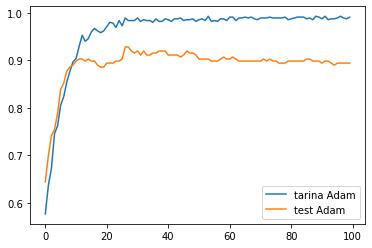

In [44]:
plt.plot(history.history['categorical_accuracy'], label = "tarina Adam")
plt.plot(history.history['val_categorical_accuracy'], label = "test Adam")

plt.legend()
plt.show()

# Zad.

Naucz jak najlepszy model na tym zbiorze danych.